In [1]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
#import xarray as xr
import pandas as pd
import joblib
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/tomislav_galjanic/miniforge3/envs/tf24/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# shape library
import shap

In [5]:
# print the JS visualization code to the notebook
shap.initjs()

In [6]:
os.getcwd()

'/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/Modeling'

In [7]:
train_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/train.csv')
test_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/test.csv')

In [9]:
test_df.describe()

EP_UNEMP         EP_PCI       EP_POV     EP_NOVEH    EP_NOHSDP  \
count  2973.000000    2976.000000  2972.000000  2971.000000  2977.000000   
mean      8.067037   28391.974126    16.993102     9.880781    12.979342   
std       5.533451   13515.934969    12.935581    12.950432     9.808189   
min       0.000000       6.000000     0.000000     0.000000     0.000000   
25%       4.400000   19736.250000     7.300000     2.650000     5.700000   
50%       6.600000   25543.500000    13.600000     5.500000    10.500000   
75%      10.000000   33482.250000    23.425000    11.450000    18.000000   
max      43.800000  139678.000000   100.000000   100.000000   100.000000   

         EP_MOBILE    EP_MINRTY     EP_CROWD     EP_AGE65     EP_AGE17  \
count  2972.000000  2996.000000  2996.000000  2977.000000  2996.000000   
mean      6.413190    33.215454     2.549599    15.430131    22.030207   
std      11.392921    28.191928     3.892751     7.983248     6.838481   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    10.100000     0.400000    10.500000    18.600000   
50%       0.700000    23.700000     1.400000    14.700000    22.400000   
75%       8.100000    50.575000     3.200000    18.900000    26.000000   
max     100.000000   100.000000   100.000000   100.000000    53.900000   

              AFAM        WHITE     HISPANIC   WFIR_AFREQ   HRCN_AFREQ  \
count  3008.000000  3008.000000  3008.000000  2993.000000  2577.000000   
mean     15.963763   149.003989    14.116024     0.000293     0.092543   
std      31.990017   140.671316    31.351120     0.001192     0.094678   
min       0.000000     0.000000     0.000000     0.000000     0.005361   
25%       1.000000    54.000000     1.000000     0.000003     0.011968   
50%       5.000000   122.000000     5.000000     0.000021     0.059841   
75%      16.000000   202.000000    14.000000     0.000132     0.161570   
max     484.000000  1908.000000   907.000000     0.035338     0.430854   

        CFLD_AFREQ   RFLD_AFREQ   HWAV_AFREQ    POPULATION    EVICTIONS  
count  1394.000000  2994.000000  2994.000000   3008.000000  3008.000000  
mean      1.006092     1.830122     0.938766   4293.026596    22.280585  
std       1.637243     1.921024     1.450644   2103.466846    31.516842  
min       0.000000     0.000000     0.000000      0.000000     0.000000  
25%       0.000000     0.541667     0.164745   2859.500000     4.000000  
50%       0.002000     1.458333     0.494234   4066.000000    11.000000  
75%       2.037666     2.458333     0.988468   5432.000000    27.000000  
max       4.512000    12.666670     8.731466  28926.000000   277.000000

### Transform AFAM, WHITE, and HISPANIC to proportion of total population

In [10]:
def per_pop(population, feature):
    if population > 0:
        return 100 * feature/population
    else:
        return np.nan

In [11]:
train_df['EVICTIONS'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['EVICTIONS']), axis=1)
train_df['AFAM'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
train_df['WHITE'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
train_df['HISPANIC'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [12]:
train_df.describe()

EP_UNEMP         EP_PCI        EP_POV      EP_NOVEH     EP_NOHSDP  \
count  11892.000000   11907.000000  11884.000000  11878.000000  11911.000000   
mean       7.951892   28557.180986     16.459635      9.359151     12.745294   
std        5.538075   13485.964541     12.734019     11.922755      9.427160   
min        0.000000     238.000000      0.000000      0.000000      0.000000   
25%        4.300000   19966.000000      7.200000      2.500000      5.700000   
50%        6.500000   25738.000000     13.100000      5.400000     10.400000   
75%       10.000000   33788.000000     22.200000     11.000000     17.600000   
max       59.300000  140255.000000    100.000000    100.000000     66.900000   

          EP_MOBILE     EP_MINRTY      EP_CROWD      EP_AGE65      EP_AGE17  \
count  11881.000000  11989.000000  11989.000000  11912.000000  11989.000000   
mean       6.583116     32.903637      2.497798     15.466429     22.105030   
std       11.411780     27.998938      3.490491      7.688546      6.699485   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      9.700000      0.400000     10.500000     18.700000   
50%        0.800000     23.900000      1.400000     14.900000     22.400000   
75%        8.300000     50.200000      3.300000     19.000000     26.000000   
max      100.000000    100.000000    100.000000    100.000000     53.600000   

               AFAM         WHITE      HISPANIC    WFIR_AFREQ    HRCN_AFREQ  \
count  11913.000000  11913.000000  11913.000000  11970.000000  10340.000000   
mean       0.362745      3.378306      0.309017      0.000300      0.093429   
std        0.594257      2.388544      0.499495      0.001233      0.093278   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.027579      1.784615      0.044199      0.000003      0.011968   
50%        0.126077      3.182686      0.134626      0.000023      0.065002   
75%        0.448029      4.571704      0.362976      0.000134      0.161570   
max        9.983361     50.000000     13.135593      0.048083      0.443213   

        CFLD_AFREQ    RFLD_AFREQ    HWAV_AFREQ    POPULATION     EVICTIONS  
count  5522.000000  11970.000000  11970.000000  12023.000000  11913.000000  
mean      1.028563      1.850286      0.882896   4261.110538      0.551709  
std       1.634605      1.960736      1.399491   2167.705352      0.776101  
min       0.000000      0.000000      0.000000      0.000000      0.000000  
25%       0.000000      0.583333      0.082372   2852.000000      0.094572  
50%       0.002000      1.458333      0.411862   4001.000000      0.255247  
75%       2.049602      2.458333      0.988468   5346.500000      0.668258  
max       4.512000     12.666670      8.731466  53812.000000      9.935760

In [13]:
test_df['EVICTIONS'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['EVICTIONS']), axis=1)
test_df['AFAM'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
test_df['WHITE'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
test_df['HISPANIC'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [14]:
test_df.describe()

EP_UNEMP         EP_PCI       EP_POV     EP_NOVEH    EP_NOHSDP  \
count  2973.000000    2976.000000  2972.000000  2971.000000  2977.000000   
mean      8.067037   28391.974126    16.993102     9.880781    12.979342   
std       5.533451   13515.934969    12.935581    12.950432     9.808189   
min       0.000000       6.000000     0.000000     0.000000     0.000000   
25%       4.400000   19736.250000     7.300000     2.650000     5.700000   
50%       6.600000   25543.500000    13.600000     5.500000    10.500000   
75%      10.000000   33482.250000    23.425000    11.450000    18.000000   
max      43.800000  139678.000000   100.000000   100.000000   100.000000   

         EP_MOBILE    EP_MINRTY     EP_CROWD     EP_AGE65     EP_AGE17  \
count  2972.000000  2996.000000  2996.000000  2977.000000  2996.000000   
mean      6.413190    33.215454     2.549599    15.430131    22.030207   
std      11.392921    28.191928     3.892751     7.983248     6.838481   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    10.100000     0.400000    10.500000    18.600000   
50%       0.700000    23.700000     1.400000    14.700000    22.400000   
75%       8.100000    50.575000     3.200000    18.900000    26.000000   
max     100.000000   100.000000   100.000000   100.000000    53.900000   

              AFAM        WHITE     HISPANIC   WFIR_AFREQ   HRCN_AFREQ  \
count  2978.000000  2978.000000  2978.000000  2993.000000  2577.000000   
mean      0.349333     3.320683     0.292315     0.000293     0.092543   
std       0.571294     2.477493     0.499347     0.001192     0.094678   
min       0.000000     0.000000     0.000000     0.000000     0.005361   
25%       0.028211     1.694489     0.044336     0.000003     0.011968   
50%       0.122894     3.095142     0.126396     0.000021     0.059841   
75%       0.422833     4.494787     0.340929     0.000132     0.161570   
max       7.861793    38.068182    11.111111     0.035338     0.430854   

        CFLD_AFREQ   RFLD_AFREQ   HWAV_AFREQ    POPULATION    EVICTIONS  
count  1394.000000  2994.000000  2994.000000   3008.000000  2978.000000  
mean      1.006092     1.830122     0.938766   4293.026596     0.589067  
std       1.637243     1.921024     1.450644   2103.466846     1.269408  
min       0.000000     0.000000     0.000000      0.000000     0.000000  
25%       0.000000     0.541667     0.164745   2859.500000     0.097182  
50%       0.002000     1.458333     0.494234   4066.000000     0.269906  
75%       2.037666     2.458333     0.988468   5432.000000     0.686516  
max       4.512000    12.666670     8.731466  28926.000000    52.941176

In [57]:
test_df[test_df['EVICTIONS']>10].shape[0]

2

In [15]:
XY_var = list(train_df.columns)
XY_var.pop(0)
XY_var

['EP_UNEMP',
 'EP_PCI',
 'EP_POV',
 'EP_NOVEH',
 'EP_NOHSDP',
 'EP_MOBILE',
 'EP_MINRTY',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ',
 'POPULATION',
 'EVICTIONS']

In [16]:
corr_train = train_df[XY_var].corr()
corr_train_df = pd.DataFrame(corr_train, index=XY_var, columns=XY_var)

<Axes:title={'center':'Training data corrrelation'}>

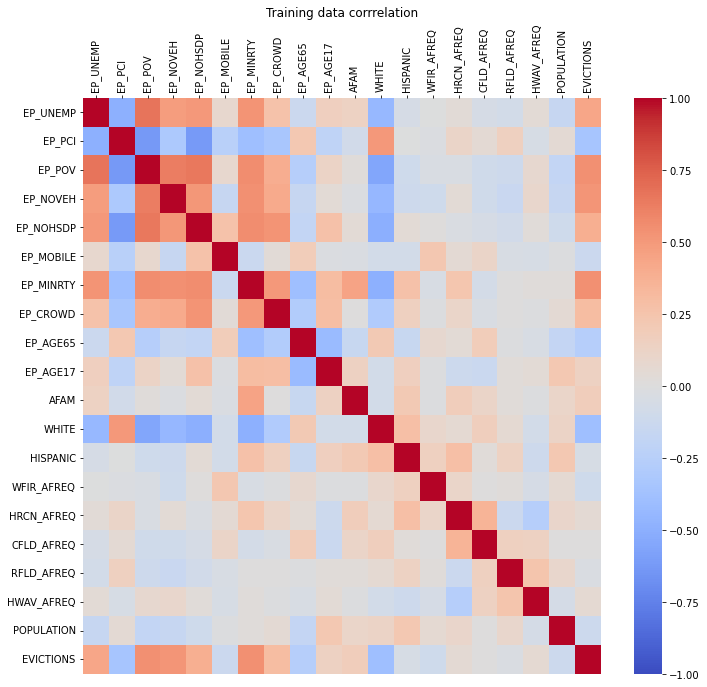

In [17]:
fig = plt.figure(figsize = (9,8))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_ticks_position("top")
plt.title("Training data corrrelation")
sns.heatmap(corr_train_df, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

In [18]:
corr_train

EP_UNEMP    EP_PCI    EP_POV  EP_NOVEH  EP_NOHSDP  EP_MOBILE  \
EP_UNEMP    1.000000 -0.494504  0.667656  0.480295   0.505420   0.081013   
EP_PCI     -0.494504  1.000000 -0.627638 -0.315351  -0.624941  -0.242241   
EP_POV      0.667656 -0.627638  1.000000  0.625888   0.650145   0.081327   
EP_NOVEH    0.480295 -0.315351  0.625888  1.000000   0.509378  -0.157552   
EP_NOHSDP   0.505420 -0.624941  0.650145  0.509378   1.000000   0.258484   
EP_MOBILE   0.081013 -0.242241  0.081327 -0.157552   0.258484   1.000000   
EP_MINRTY   0.523932 -0.395673  0.557239  0.545769   0.561454  -0.135218   
EP_CROWD    0.260525 -0.339120  0.391731  0.412020   0.530635   0.031791   
EP_AGE65   -0.131219  0.226022 -0.261701 -0.157763  -0.185375   0.184242   
EP_AGE17    0.158638 -0.204797  0.123653  0.041187   0.268560  -0.019484   
AFAM        0.137845 -0.091611  0.022880 -0.018980   0.044132  -0.029871   
WHITE      -0.442633  0.502674 -0.558273 -0.449826  -0.505274  -0.080464   
HISPANIC   -0.060405 -0.003104 -0.103589 -0.114913   0.044502  -0.080243   
WFIR_AFREQ -0.007802 -0.023061 -0.031918 -0.103168   0.014053   0.230295   
HRCN_AFREQ  0.038120  0.113074 -0.033659  0.046226  -0.025519   0.049931   
CFLD_AFREQ -0.056012  0.054050 -0.096322 -0.095743  -0.054705   0.110151   
RFLD_AFREQ -0.082464  0.153281 -0.112155 -0.147296  -0.092834  -0.045591   
HWAV_AFREQ  0.043835 -0.053258  0.071541  0.091013   0.027118  -0.050702   
POPULATION -0.159476  0.053508 -0.187447 -0.163215  -0.107469  -0.009269   
EVICTIONS   0.436363 -0.348056  0.539311  0.521911   0.390142  -0.125341   

            EP_MINRTY  EP_CROWD  EP_AGE65  EP_AGE17      AFAM     WHITE  \
EP_UNEMP     0.523932  0.260525 -0.131219  0.158638  0.137845 -0.442633   
EP_PCI      -0.395673 -0.339120  0.226022 -0.204797 -0.091611  0.502674   
EP_POV       0.557239  0.391731 -0.261701  0.123653  0.022880 -0.558273   
EP_NOVEH     0.545769  0.412020 -0.157763  0.041187 -0.018980 -0.449826   
EP_NOHSDP    0.561454  0.530635 -0.185375  0.268560  0.044132 -0.505274   
EP_MOBILE   -0.135218  0.031791  0.184242 -0.019484 -0.029871 -0.080464   
EP_MINRTY    1.000000  0.500723 -0.393476  0.300892  0.448679 -0.495516   
EP_CROWD     0.500723  1.000000 -0.284238  0.292757  0.002116 -0.295063   
EP_AGE65    -0.393476 -0.284238  1.000000 -0.423751 -0.150188  0.217097   
EP_AGE17     0.300892  0.292757 -0.423751  1.000000  0.146463 -0.084231   
AFAM         0.448679  0.002116 -0.150188  0.146463  1.000000 -0.079873   
WHITE       -0.495516 -0.295063  0.217097 -0.084231 -0.079873  1.000000   
HISPANIC     0.271573  0.151971 -0.150216  0.159874  0.214894  0.282341   
WFIR_AFREQ  -0.046169 -0.009739  0.074157 -0.008671 -0.015409  0.087494   
HRCN_AFREQ   0.235594  0.102497  0.040198 -0.118523  0.178778  0.059448   
CFLD_AFREQ  -0.077628 -0.031708  0.180654 -0.139132  0.114516  0.169694   
RFLD_AFREQ   0.007396  0.002890 -0.012107  0.026828  0.025014  0.062424   
HWAV_AFREQ   0.020745 -0.008243 -0.043878  0.040827 -0.008216 -0.082834   
POPULATION   0.016362  0.048259 -0.176225  0.225465  0.108224  0.119429   
EVICTIONS    0.545172  0.298167 -0.260023  0.144340  0.174300 -0.391413   

            HISPANIC  WFIR_AFREQ  HRCN_AFREQ  CFLD_AFREQ  RFLD_AFREQ  \
EP_UNEMP   -0.060405   -0.007802    0.038120   -0.056012   -0.082464   
EP_PCI     -0.003104   -0.023061    0.113074    0.054050    0.153281   
EP_POV     -0.103589   -0.031918   -0.033659   -0.096322   -0.112155   
EP_NOVEH   -0.114913   -0.103168    0.046226   -0.095743   -0.147296   
EP_NOHSDP   0.044502    0.014053   -0.025519   -0.054705   -0.092834   
EP_MOBILE  -0.080243    0.230295    0.049931    0.110151   -0.045591   
EP_MINRTY   0.271573   -0.046169    0.235594   -0.077628    0.007396   
EP_CROWD    0.151971   -0.009739    0.102497   -0.031708    0.002890   
EP_AGE65   -0.150216    0.074157    0.040198    0.180654   -0.012107   
EP_AGE17    0.159874   -0.008671   -0.118523   -0.139132    0.026828   
AFAM        0.214894   -0.015409    0.178778   

### Examine multicollinearity between features using Variance Inflation Factor

In [22]:
X_var = copy.deepcopy(XY_var)
X_var.remove('EVICTIONS')
X_var.remove('POPULATION')
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [23]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         54.274716
EP_MINRTY      5.748367
EP_POV         3.815474
EP_NOHSDP      3.468006
EP_NOVEH       3.041253
WHITE          2.684534
EP_PCI         2.452304
EP_UNEMP       2.240264
EP_CROWD       1.877264
AFAM           1.670352
EP_AGE65       1.635415
EP_AGE17       1.608447
HISPANIC       1.568768
HRCN_AFREQ     1.520386
RFLD_AFREQ     1.452642
EP_MOBILE      1.440626
HWAV_AFREQ     1.396111
CFLD_AFREQ     1.302713
WFIR_AFREQ     1.123669
dtype: float64

In [30]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ'
]
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [31]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         44.929572
EP_NOVEH       2.199315
WHITE          2.048691
EP_PCI         1.962866
EP_UNEMP       1.776803
EP_CROWD       1.723336
EP_AGE65       1.559881
EP_AGE17       1.499917
HRCN_AFREQ     1.454215
RFLD_AFREQ     1.448442
HWAV_AFREQ     1.384048
HISPANIC       1.309997
EP_MOBILE      1.298389
CFLD_AFREQ     1.297645
AFAM           1.206151
WFIR_AFREQ     1.122971
dtype: float64

### Final  feature selection and data prep

In [32]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_AFREQ',
 'HRCN_AFREQ',
 'CFLD_AFREQ',
 'RFLD_AFREQ',
 'HWAV_AFREQ']
Y_var = ['EVICTIONS']

In [33]:
train_sel = ~train_df[Y_var].isna().any(axis=1)
#train_sel = ~train_df[X_var+Y_var].isna().any(axis=1)
sum(train_sel)

11913

In [34]:
#X_train = train_df.loc[train_sel,X_var].to_numpy()
#y_train = train_df.loc[train_sel,Y_var].to_numpy().ravel()
X_train = train_df.loc[train_sel,X_var]
y_train = train_df.loc[train_sel,Y_var]

In [35]:
test_sel = ~test_df[Y_var].isna().any(axis=1)
#test_sel = ~test_df[X_var+Y_var].isna().any(axis=1)
sum(test_sel)

2978

In [36]:
#X_test = test_df.loc[test_sel,X_var].to_numpy()
#y_test = test_df.loc[test_sel,Y_var].to_numpy().ravel()
X_test = test_df.loc[test_sel,X_var]
y_test = test_df.loc[test_sel,Y_var]

## XGBoost Model Specification

In [37]:
# Parameter grids
xg_param_grid = {"n_estimators":[50, 100, 250, 500],
                 "max_depth":[3,4,5,6]
                }

In [38]:
kf = KFold(n_splits=5).split(X_train,y_train)
xg_model = XGBRegressor(random_state=123)
grid = GridSearchCV(xg_model, xg_param_grid, scoring='neg_mean_squared_error', cv=kf, return_train_score=False, refit=True)

In [39]:
print(datetime.datetime.now())

grid.fit(X_train,y_train)
best_params = grid.best_params_
print(best_params)

print(datetime.datetime.now())

2021-12-01 18:42:38.803447
{'max_depth': 4, 'n_estimators': 100}
2021-12-01 18:44:07.861166


In [40]:
# Fit the model on train data using optimal hyperparameters 
xg_model = XGBRegressor(random_state=123, **best_params)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## XGBoost Model evaluation

In [41]:
def evaluate_predict(y, pred):
    scores = {
        'mse':mean_squared_error(y, pred),
        'rmse':np.sqrt(mean_squared_error(y, pred)),
        'mae':mean_absolute_error(y, pred),
        'medae':median_absolute_error(y, pred),
        'max_error':max_error(y, pred),
        'bias':pred.mean() - y.mean(),
        'r2':r2_score(y, pred),
        'corr':np.corrcoef(y,pred)[0,1],
        }
    return scores

### Train data metrics

In [42]:
# Calculate test data error metrics
y_pred_train = xg_model.predict(X_train)

resid_train = y_train['EVICTIONS'].values - y_pred_train
df_results_train = pd.DataFrame({'y_train':y_train['EVICTIONS'].values, 'y_pred_train': y_pred_train, 'resid_train': resid_train})

In [43]:
train_scores = evaluate_predict(y_train['EVICTIONS'].values, y_pred_train)
train_scores

{'mse': 0.12607484583925757,
 'rmse': 0.3550701984668068,
 'mae': 0.2230436818929994,
 'medae': 0.1377962973620681,
 'max_error': 4.520838887584286,
 'bias': -9.22227673230136e-05,
 'r2': 0.7906715467262376,
 'corr': 0.8916892871991944}

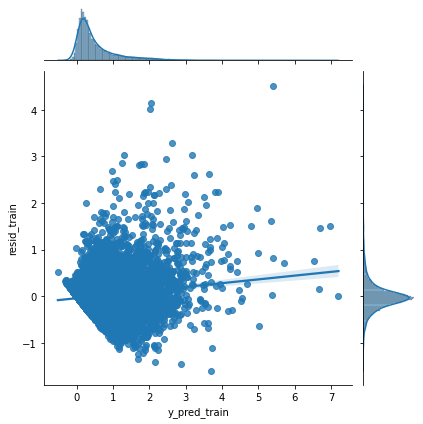

In [44]:
sns.jointplot(x = 'y_pred_train', y = 'resid_train', data = df_results_train, kind = 'reg')

### Test data metrics

In [97]:
X_test_out = X_test[y_test['EVICTIONS']<10]
y_test_out = y_test[y_test['EVICTIONS']<10]

In [95]:
y_test

EVICTIONS
0      0.031377
1      0.436031
2      0.206540
3      0.262217
4      0.108460
...         ...
3003   0.092109
3004   0.049554
3005   0.216365
3006   0.071098
3007   0.000000

[2978 rows x 1 columns]

In [98]:
# Calculate test data error metrics
y_pred_test = xg_model.predict(X_test_out)

resid_test = y_test_out['EVICTIONS'].values - y_pred_test
df_results = pd.DataFrame({'y_test':y_test_out['EVICTIONS'].values, 'y_pred_test': y_pred_test, 'resid_test': resid_test})

In [99]:
test_scores = evaluate_predict(y_test_out['EVICTIONS'].values, y_pred_test)
test_scores

{'mse': 0.25642088500538635,
 'rmse': 0.5063801783298655,
 'mae': 0.29633958678957933,
 'medae': 0.16602166066701332,
 'max_error': 5.49560683831357,
 'bias': 0.009687314531592217,
 'r2': 0.5843550597777689,
 'corr': 0.7652232105124398}

In [45]:
# Calculate test data error metrics
y_pred_test = xg_model.predict(X_test)

resid_test = y_test['EVICTIONS'].values - y_pred_test
df_results = pd.DataFrame({'y_test':y_test['EVICTIONS'].values, 'y_pred_test': y_pred_test, 'resid_test': resid_test})

In [46]:
test_scores = evaluate_predict(y_test['EVICTIONS'].values, y_pred_test)
test_scores

{'mse': 1.2210332705739277,
 'rmse': 1.1050037423348067,
 'mae': 0.31805509030455226,
 'medae': 0.16615765927296244,
 'max_error': 51.9128428066478,
 'bias': -0.012233741202095194,
 'r2': 0.24199727611187438,
 'corr': 0.49203067161461705}

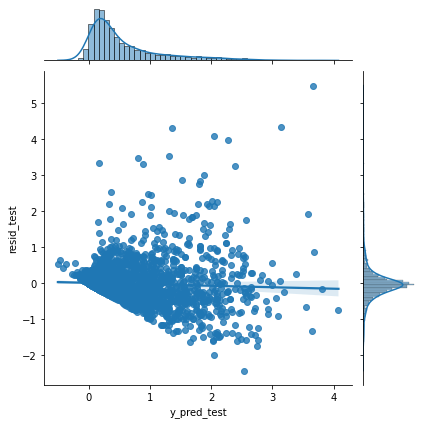

In [100]:
sns.jointplot(x = 'y_pred_test', y = 'resid_test', data = df_results, kind = 'reg')

[Text(0.5, 0, 'y_test predicted'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Histogram of y_test predicted'),
 (0.0, 1500.0)]

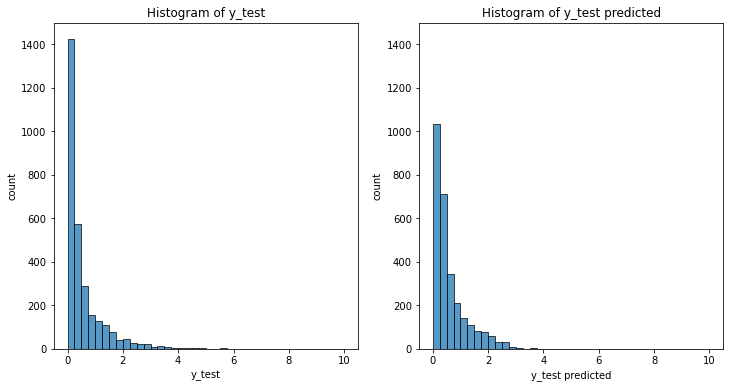

In [82]:
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
sns.histplot(y_pred_test, kde=False,  binwidth = 0.25, binrange = (0,10), ax = ax[1])
sns.histplot(y_test['EVICTIONS'], kde=False, binwidth = 0.25, binrange = (0,10), ax = ax[0])

ax[0].set(xlabel='y_test', ylabel='count', title='Histogram of y_test', ylim=[0,1500])
ax[1].set(xlabel='y_test predicted', ylabel='count', title='Histogram of y_test predicted', ylim=[0,1500])

<Axes:ylabel='Count'>

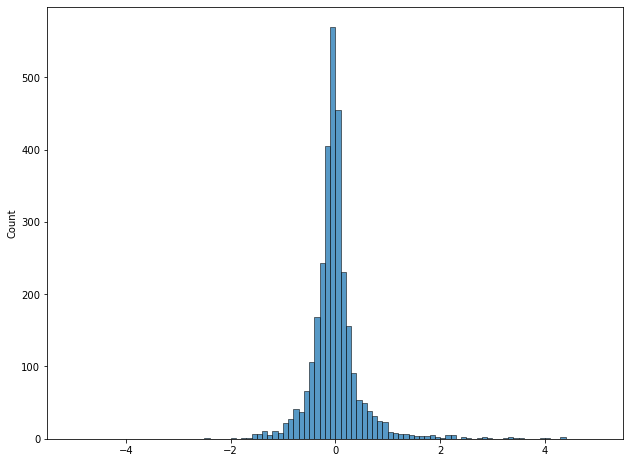

In [101]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_axes([0,0,1,1])
sns.histplot(resid_test, kde=False, binwidth = 0.1, binrange = (-5,5))

In [106]:
np.mean(y_test)

EVICTIONS    0.589067
dtype: float64

In [105]:
np.std(y_test)

EVICTIONS    1.269195
dtype: float64

## Feature importance

In [58]:
# explain the model's predictions using SHAP
t_explainer = shap.TreeExplainer(xg_model)
t_shap_values = t_explainer(X_test)
shap_values = t_explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [201]:
# visualize all the training set predictions
shap.plots.force(t_shap_values)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [94]:
np.mean(y_pred_test)

0.57683283

In [89]:
t_shap_values

.values =
array([[ 0.03013218, -0.04557826, -0.11826546, ...,  0.01686314,
        -0.02792465, -0.09367627],
       [-0.04028537,  0.03690104, -0.18732114, ..., -0.01597333,
         0.01812945,  0.02277857],
       [ 0.04459786,  0.04409558,  0.01159536, ..., -0.00701033,
         0.03025982,  0.00869872],
       ...,
       [ 0.09901471,  0.00752739, -0.16711509, ...,  0.00428491,
        -0.0236574 ,  0.05989332],
       [-0.02288845,  0.01919896, -0.13270405, ...,  0.01617555,
        -0.00973539,  0.08100127],
       [-0.01415391,  0.01140416, -0.15769598, ...,  0.01516855,
         0.00188876,  0.08250584]], dtype=float32)

.base_values =
array([0.55161697, 0.55161697, 0.55161697, ..., 0.55161697, 0.55161697,
       0.55161697], dtype=float32)

.data =
array([[8.10000000e+00, 3.41050000e+04, 5.80000000e+00, ...,
                   nan, 1.08333333e+00, 4.11861614e-01],
       [5.60000000e+00, 2.73750000e+04, 2.20000000e+00, ...,
        2.06558614e+00, 2.70833333e+00, 8.36241625e

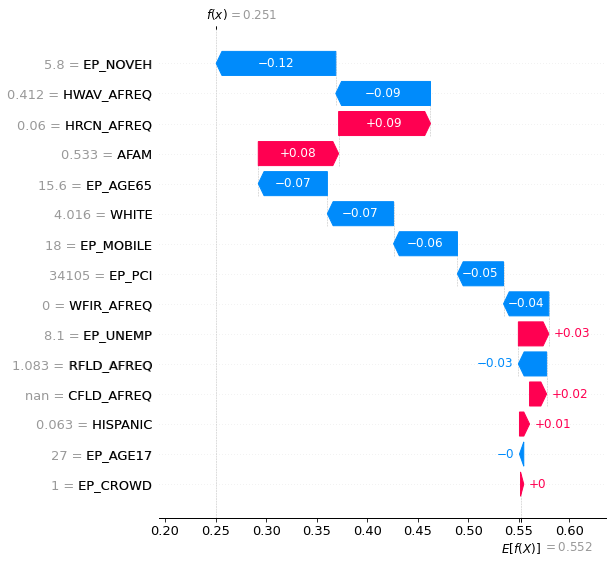

In [87]:
# visualize the first prediction's explanation
shap.waterfall_plot(t_shap_values[0], max_display=20)

In [86]:
t_shap_values.values[0]

array([ 0.03013218, -0.04557826, -0.11826546, -0.06315898,  0.00317494,
       -0.06833579, -0.00424513,  0.07944963, -0.06546962,  0.00997731,
       -0.04482693,  0.09087322,  0.01686314, -0.02792465, -0.09367627],
      dtype=float32)

In [88]:
X_test.columns

Index(['EP_UNEMP', 'EP_PCI', 'EP_NOVEH', 'EP_MOBILE', 'EP_CROWD', 'EP_AGE65',
       'EP_AGE17', 'AFAM', 'WHITE', 'HISPANIC', 'WFIR_AFREQ', 'HRCN_AFREQ',
       'CFLD_AFREQ', 'RFLD_AFREQ', 'HWAV_AFREQ'],
      dtype='object')

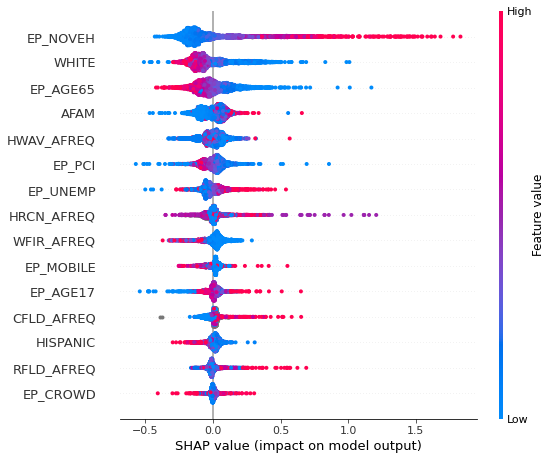

In [59]:
shap.plots.beeswarm(t_shap_values, max_display=20)

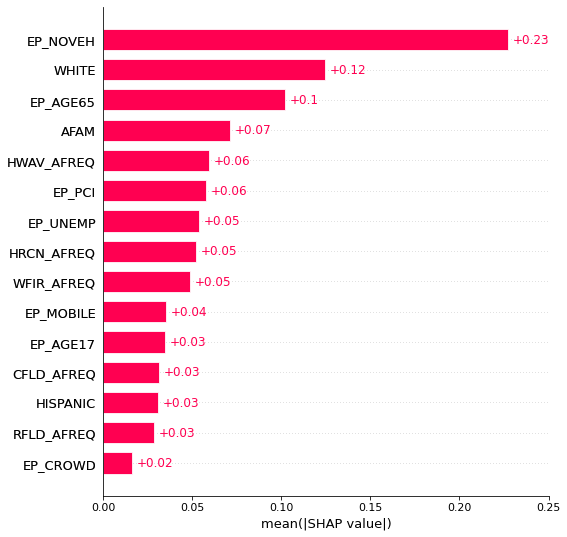

In [60]:
shap.plots.bar(t_shap_values, max_display=20)

### Dependence Plot: White (Mortgage Applicants) and Climate Disasters

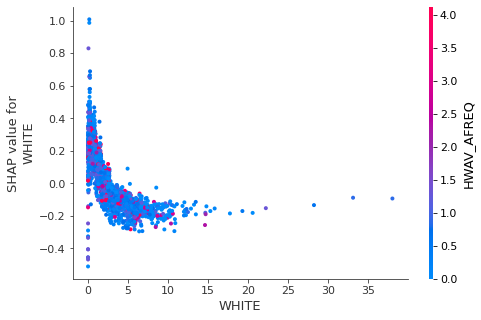

In [62]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HWAV_AFREQ")

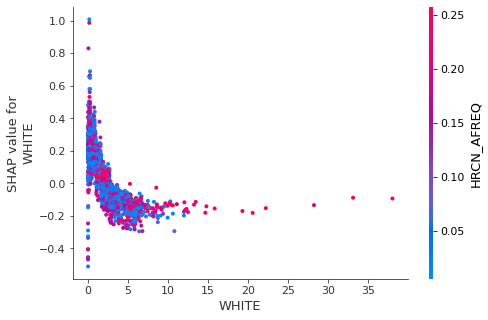

In [63]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HRCN_AFREQ")

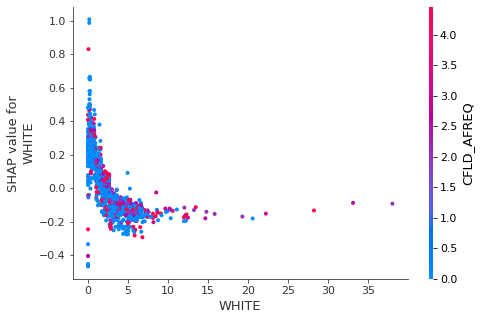

In [64]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="CFLD_AFREQ")

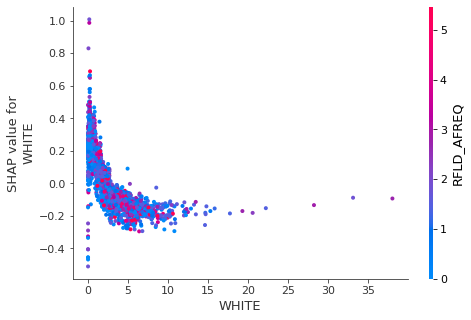

In [65]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="RFLD_AFREQ")

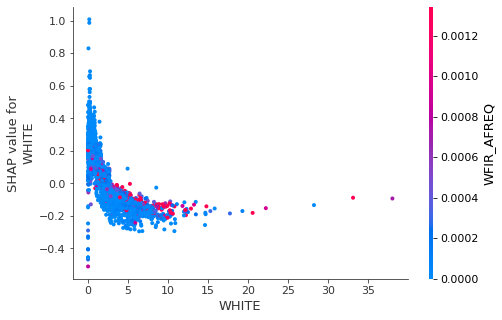

In [66]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: No Vehicles and Climate Disasters

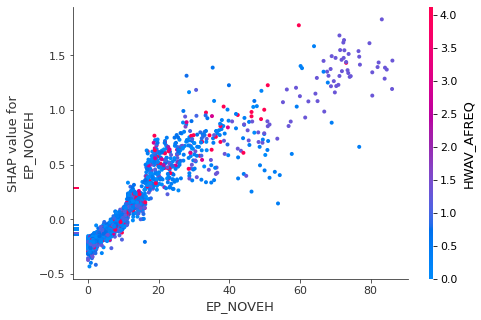

In [67]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HWAV_AFREQ")

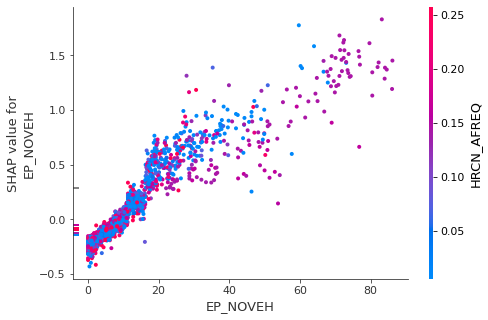

In [68]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HRCN_AFREQ")

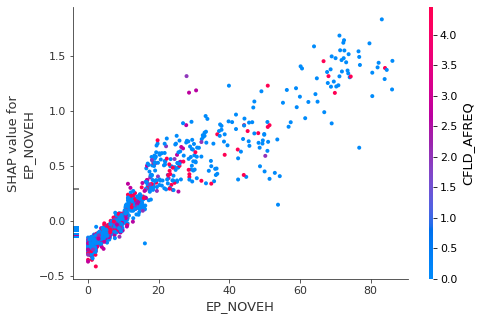

In [69]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="CFLD_AFREQ")

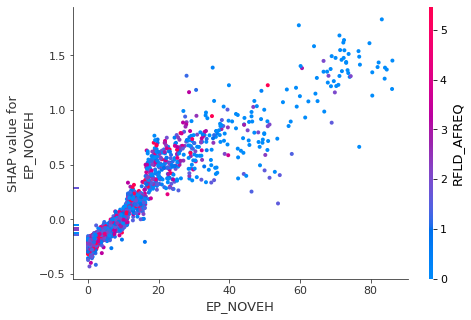

In [70]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="RFLD_AFREQ")

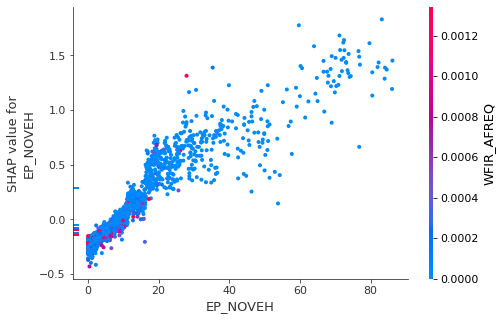

In [71]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: African-American (Mortgage Applicants) and Climate Disasters

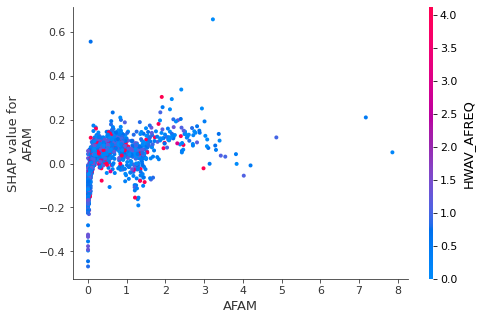

In [72]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HWAV_AFREQ")

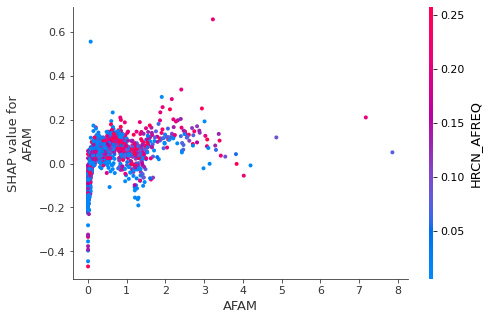

In [73]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HRCN_AFREQ")

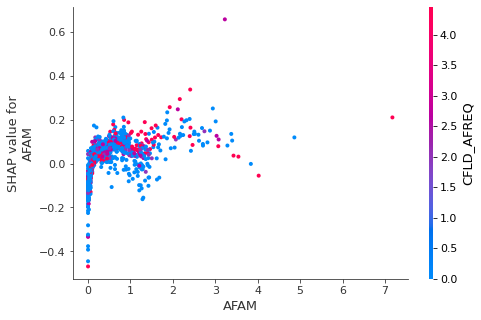

In [74]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="CFLD_AFREQ")

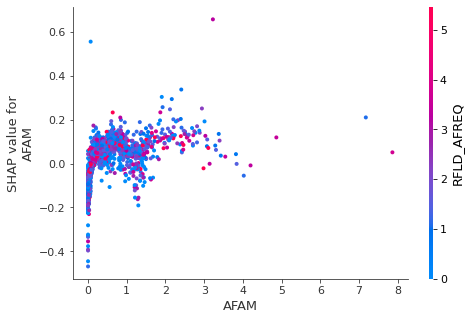

In [75]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="RFLD_AFREQ")

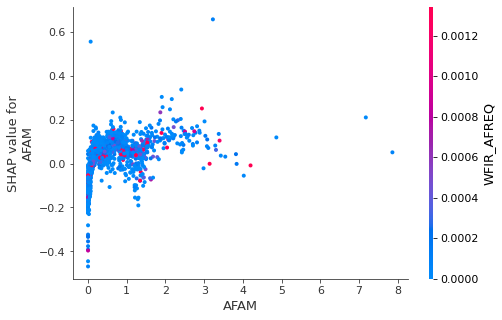

In [76]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="WFIR_AFREQ")

### Dependence Plot: Top Interaction for Each Feature

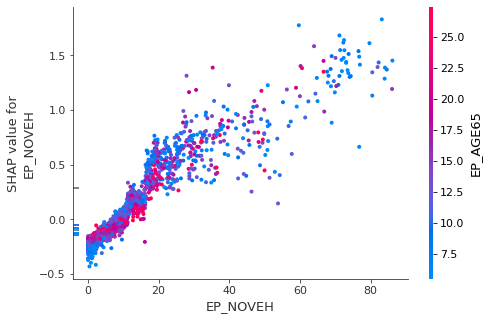

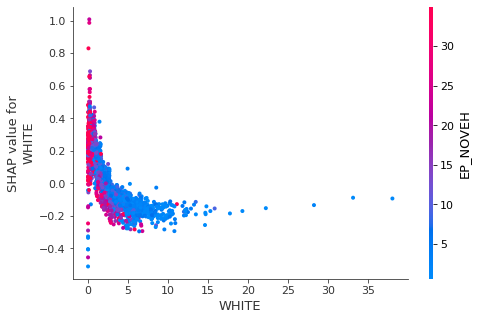

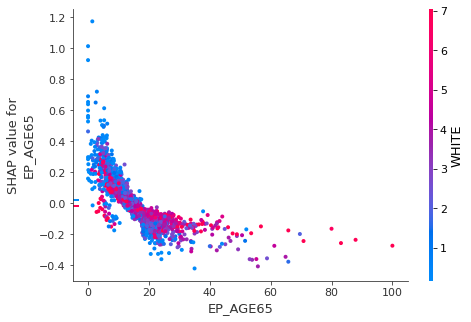

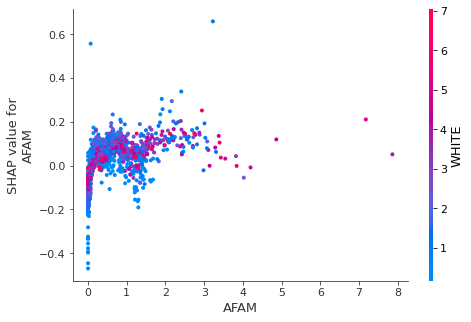

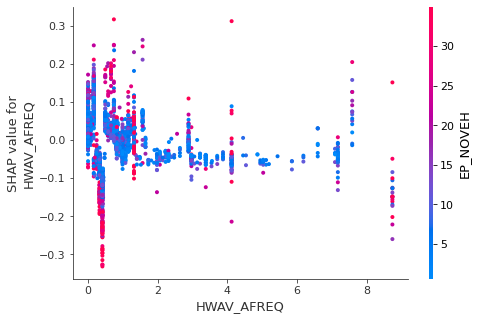

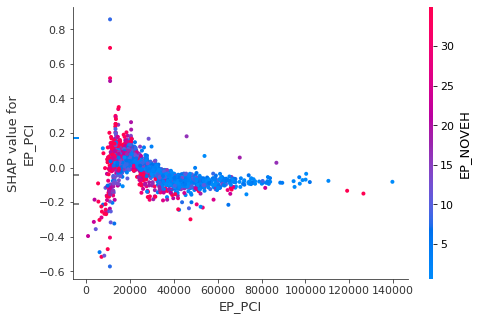

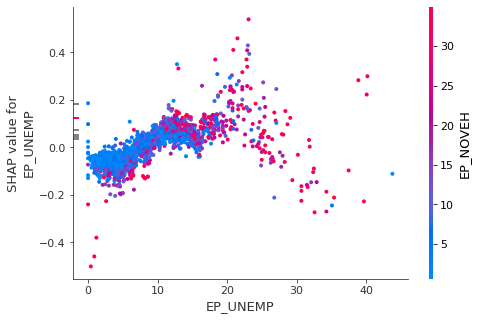

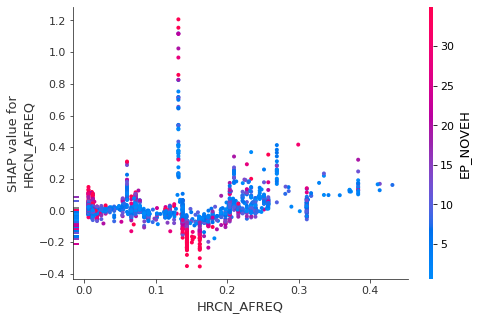

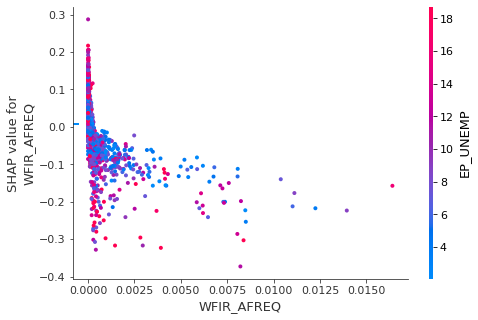

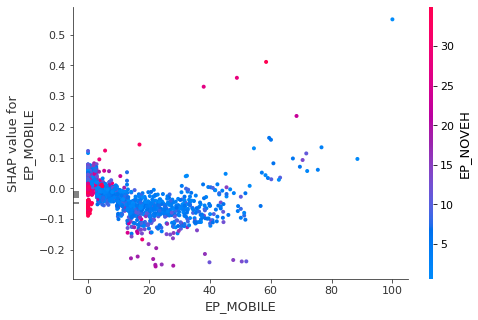

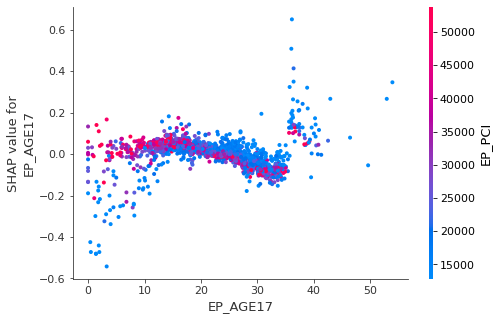

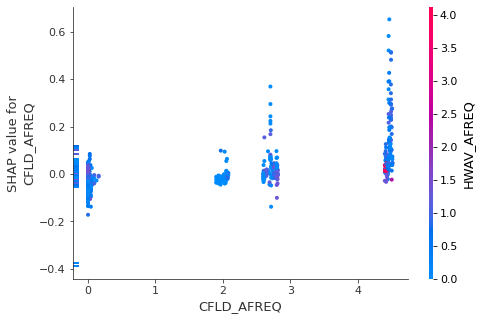

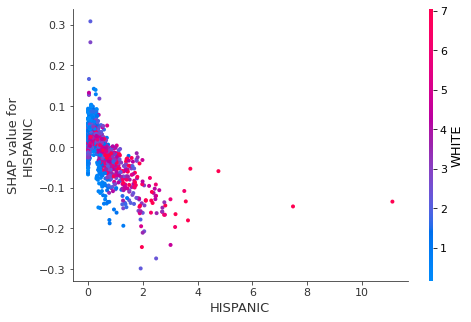

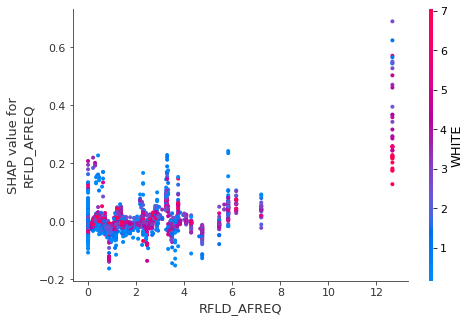

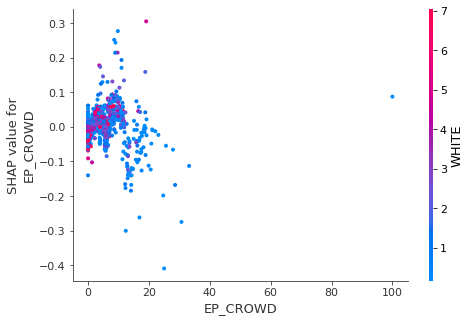

In [77]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(X_test.shape[1]):
    shap.dependence_plot(top_inds[i], shap_values, X_test)